In [1]:
import glob
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.dataviz import plot_raster
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
import _pipeline

In [2]:
path="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/in_out_b1_b2/2025_01_03_12_05_07/pfc/population.h5"

In [3]:
popu = PopulationData.from_python_hdf5(path)

In [4]:
start_sample = 0
end_sample = 400

In [5]:
st_target = 0
end_target = 400
cerotr, percentile=True,True
st_bl = -100
end_bl = 0

In [6]:
allres=[]
for i,neu in enumerate(popu.population[117:118]):
    res = _pipeline.get_space_neutral_roc(
        neu,
        start_sample,
        end_sample,
        st_target,
        end_target,
        st_bl,
        end_bl,
        cerotr=cerotr,
        percentile=percentile,
    )
    allres.append(res)

In [2]:
path='/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/neutral_space_idx/2025_01_07_14_07_06/pfc'
df = pd.read_csv(f'{path}/neutral_space_idx.csv')
df['neutral_idx'] = df['neutral_in']-df['neutral_out']
df['spatial_idx'] = df['space_in']-df['space_out']
df

,Unnamed: 0,nid,neutral_in,neutral_out,space_in,space_out,neutral_idx,spatial_idx
0,0,2022-12-01_10-23-18_Riesling_pfc_e1_r1_mua1,-0.278402,-0.259964,0.241250,NaN,-0.018438,NaN
1,1,2022-12-01_10-23-18_Riesling_pfc_e1_r1_mua2,-0.163280,-0.108705,NaN,NaN,-0.054575,NaN
2,2,2022-12-01_10-23-18_Riesling_pfc_e1_r1_good2,0.222436,NaN,NaN,NaN,NaN,NaN
3,3,2022-11-22_10-59-03_Riesling_pfc_e1_r1_mua14,0.148578,-0.154900,0.472656,0.355372,0.303478,0.117284
4,4,2023-03-09_10-35-09_Riesling_pfc_e1_r1_mua24,-0.117608,-0.114035,0.000000,0.000000,-0.003573,0.000000
...,...,...,...,...,...,...,...,...
2117,2117,2023-03-09_10-35-09_Riesling_pfc_e1_r1_mua21,0.255066,0.184641,0.319444,-0.385000,0.070425,0.704444
2118,2118,2023-03-09_10-35-09_Riesling_pfc_e1_r1_good11,0.390127,0.340162,0.275148,0.360000,0.049964,-0.084852
2119,2119,2023-03-09_10-35-09_Riesling_pfc_e1_r1_mua22,0.132892,-0.148576,0.301775,0.481481,0.281468,-0.179706
2120,2120,2023-03-09_10-35-09_Riesling_pfc_e1_r1_good12,0.198330,0.224433,-0.147929,0.000000,-0.026103,-0.147929


(-1.0, 1.0)

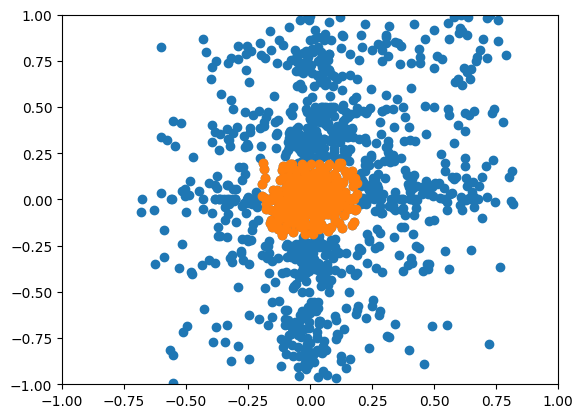

In [3]:
plt.scatter(df['neutral_idx'],df['spatial_idx'])
df_zero = df[np.logical_and(abs(df['neutral_idx'])<0.2,abs(df['spatial_idx'])<0.2)]
plt.scatter(df_zero['neutral_idx'],df_zero['spatial_idx'])
plt.xlim([-1,1])
plt.ylim([-1,1])

465

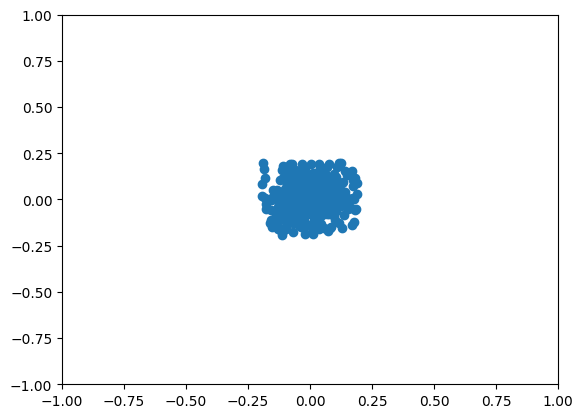

In [8]:
df_zero = df_zero[np.logical_and(~np.isnan(df_zero['neutral_idx']),~np.isnan(df_zero['spatial_idx']))]
plt.scatter(df_zero['neutral_idx'],df_zero['spatial_idx'])
plt.xlim([-1,1])
plt.ylim([-1,1])
len(df_zero)

In [9]:
listdf = df_zero[np.logical_and(abs(df_zero['neutral_idx'])>0.05,abs(df_zero['spatial_idx'])>0.05)]
listdf = listdf['nid'].values
len(listdf)

131

In [10]:
path1 = f'{path}/less_than_0.2/b1'
path2 = f'{path}/less_than_0.2/b2'
if not os.path.exists(path1):
    os.makedirs(path1)
if not os.path.exists(path2):
    os.makedirs(path2)

for nid in df_zero['nid'].values:#[np.arange(0,892,11)]:
    path_n=f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/{nid}_neu.h5'
    neu_n = NeuronData.from_python_hdf5(path_n)
    sp, conv = plot_raster.prepare_data_plotb1(neu_n,rf_stim_loc= ["contra", "ipsi"],cerotr=True,percentile=True)
    fig1=plot_raster.plot_sp_b1(neu_n,sp, conv)
    fig1.savefig(path1+'/'+nid+'.jpg',format='jpg')
    sp_pos, conv_pos, max_n_tr, conv_max = plot_raster.prepare_data_plotb2(neu_n)
    fig2 = plot_raster.plot_sp_b2(neu_n,sp_pos, conv_pos, max_n_tr, conv_max, visual_rf=True,inout=1,bl_st=100, bl_end=200, tg_st=250, tg_end=350)
    fig2.savefig(path2+'/'+nid+'.jpg',format='jpg')
    plt.close('all')

In [11]:
nid = '2022-11-22_10-59-03_Riesling_pfc_e1_r1_mua15' # listdf[6]

In [12]:
df[df['nid']==nid]

,Unnamed: 0,nid,neutral_in,neutral_out,space_in,space_out,neutral_idx,spatial_idx
14,14,2022-11-22_10-59-03_Riesling_pfc_e1_r1_mua15,-0.250622,-0.151139,0.0,0.0,-0.099483,0.0


In [13]:
path=f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/{nid}_neu.h5'
neu_n = NeuronData.from_python_hdf5(path)

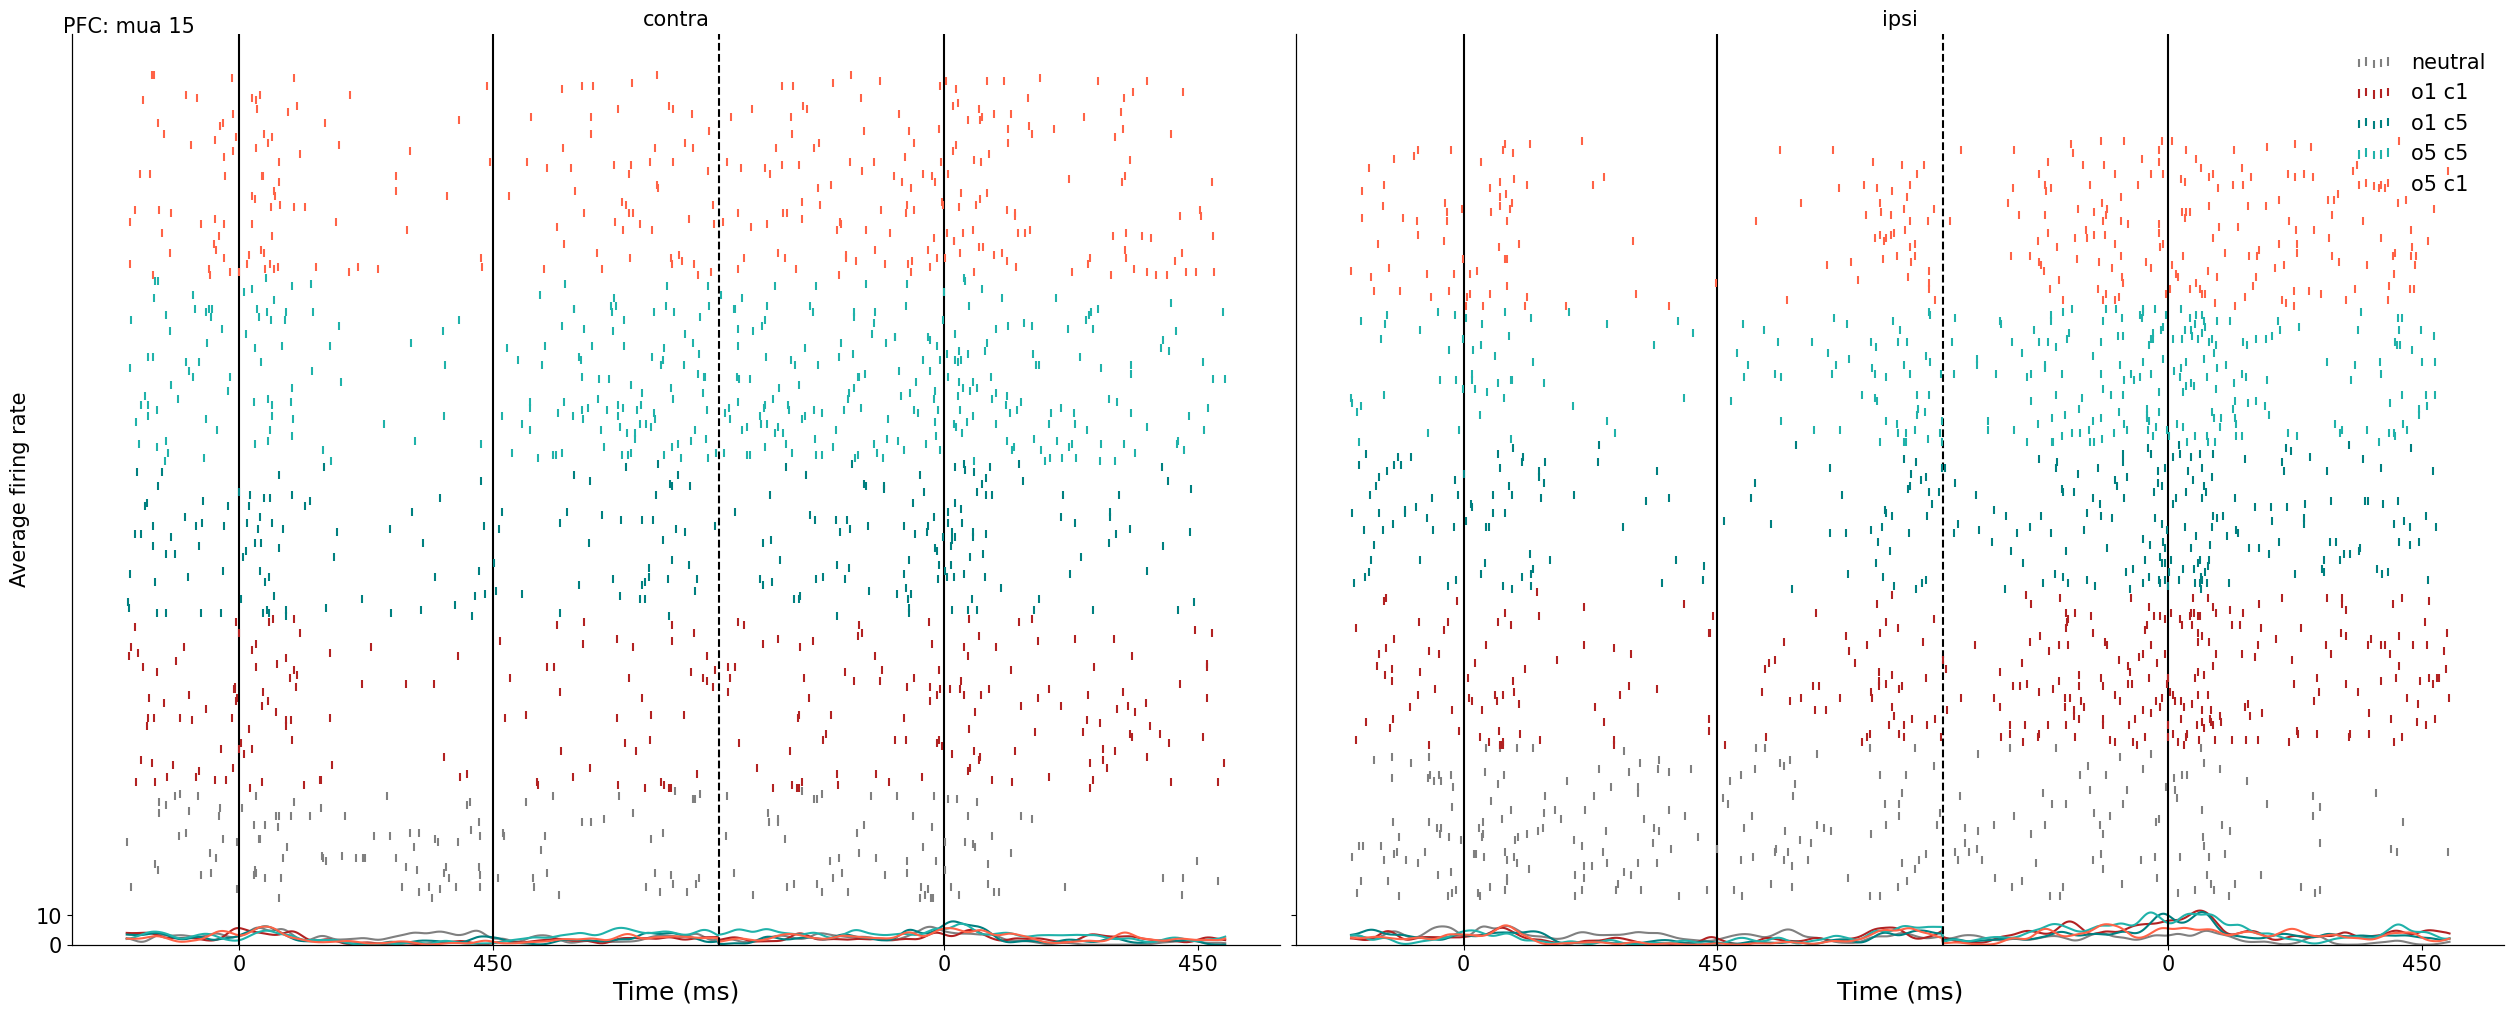

In [14]:
sp, conv = plot_raster.prepare_data_plotb1(neu_n,rf_stim_loc= ["contra", "ipsi"],cerotr=True,percentile=True)
fig=plot_raster.plot_sp_b1(neu_n,sp, conv)

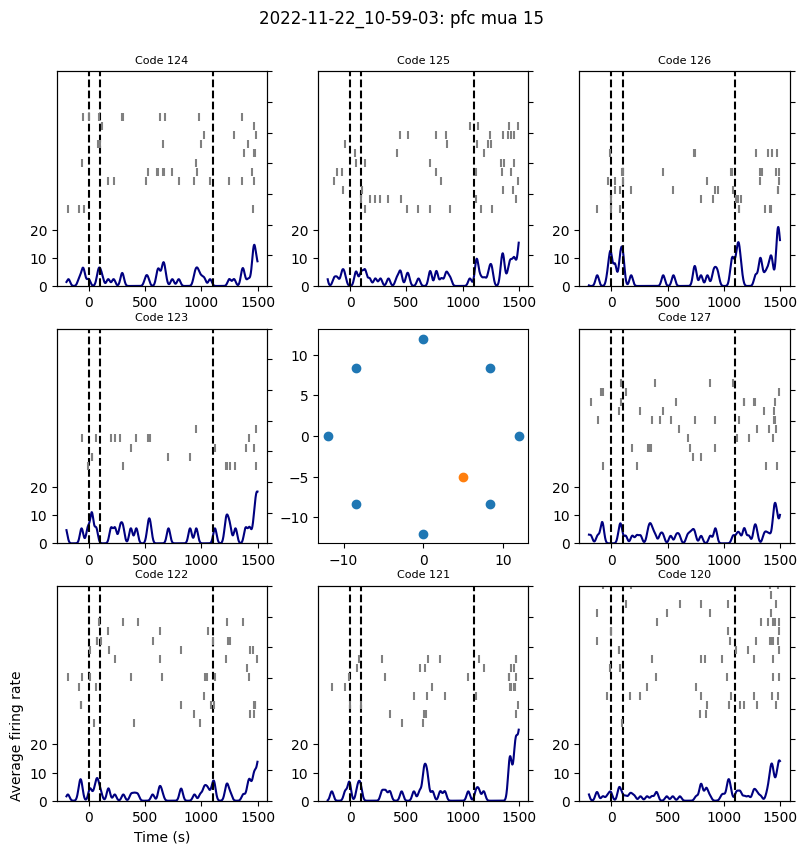

In [15]:
sp_pos, conv_pos, max_n_tr, conv_max = plot_raster.prepare_data_plotb2(neu_n)
fig = plot_raster.plot_sp_b2(neu_n,sp_pos, conv_pos, max_n_tr, conv_max, visual_rf=True,inout=1,bl_st=100, bl_end=200, tg_st=250, tg_end=350)